In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hem-3-folder/dataset/validation/no/aug_82_4270.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_46_3843.png
/kaggle/input/hem-3-folder/dataset/validation/no/173.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_0_6383.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_46_4961.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_61_630.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_40_2606.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_96_2781.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_29_4856.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_41_4007.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_27_152.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_98_2145.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_1_5807.png
/kaggle/input/hem-3-folder/dataset/validation/no/aug_13_4833.png
/kaggle/input/hem-3-folder/dataset/validation/no/162.png
/kaggle/input/hem-3-folder/dataset/validation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import cv2
import shutil
import itertools

import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras.models import Model, Sequential
from keras.layers import TimeDistributed, Dense, Flatten, Dropout, Bidirectional, LSTM, GRU
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras_preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers

#init_notebook_mode(connected=True)
RANDOM_SEED = 42

In [3]:
train_dir = "../input/hem-3-folder/dataset/train/"
validation_dir = "../input/hem-3-folder/dataset/validation/"
test_dir = "../input/hem-3-folder/dataset/test/"

In [4]:
def load_data(dir_path):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [5]:
X_train, y_train, labels = load_data(train_dir)
X_test, y_test, _ = load_data(test_dir)
X_val, y_val, _ = load_data(validation_dir)

100%|██████████| 2/2 [00:11<00:00,  5.72s/it]


1536 images loaded from ../input/hem-3-folder/dataset/train/ directory.


100%|██████████| 2/2 [00:03<00:00,  1.76s/it]


480 images loaded from ../input/hem-3-folder/dataset/test/ directory.


100%|██████████| 2/2 [00:02<00:00,  1.38s/it]

384 images loaded from ../input/hem-3-folder/dataset/validation/ directory.


In [6]:
X_train = np.array([cv2.resize(image, (224, 224)) for image in X_train])
X_test = np.array([cv2.resize(image, (224, 224)) for image in X_test])
X_val = np.array([cv2.resize(image, (224, 224)) for image in X_val])

In [7]:
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)

X_train:  (1536, 224, 224, 3)
X_val:  (384, 224, 224, 3)
X_test:  (480, 224, 224, 3)


In [8]:
input_shape = (224,224,3)
batch_size = 32

In [9]:
training_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
train_generator = training_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

val_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 1536 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [ ]:

def conv_maxpool_batchnorm_relu(x, filters, kernel_size):
    x = layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(x)    
    return x


def layer_concate(tensor,filters):
    x=conv_maxpool_batchnorm_relu(tensor,filters,kernel_size=3)
    x=layers.Concatenate()([x,tensor])
    return x


inputs=layers.Input(shape=(224,224,3))

x=conv_maxpool_batchnorm_relu(inputs,filters=32,kernel_size=3)
x=layer_concate(x,filters=32)
x=layers.MaxPool2D(pool_size=(2,2))(x)

x=conv_maxpool_batchnorm_relu(x,filters=64,kernel_size=3)
x=layer_concate(x,filters=64)
x=layers.MaxPool2D(pool_size=(2,2))(x)

x=conv_maxpool_batchnorm_relu(x,filters=128,kernel_size=3)
x=layer_concate(x,filters=128)
x=layers.MaxPool2D(pool_size=(2,2))(x)

x=layers.Flatten()(x)
x=layers.Dense(64, activation='relu')(x)
x=layers.Dropout(0.4)(x)
x=layers.Dense(128, activation='relu')(x)
x=layers.Dropout(0.4)(x)
x=layers.Dense(256, activation='relu')(x)
x=layers.Dropout(0.4)(x)

output=layers.Dense(1, activation='sigmoid')(x)

model=keras.Model(inputs,output,name='hybrid_model')

model.summary()

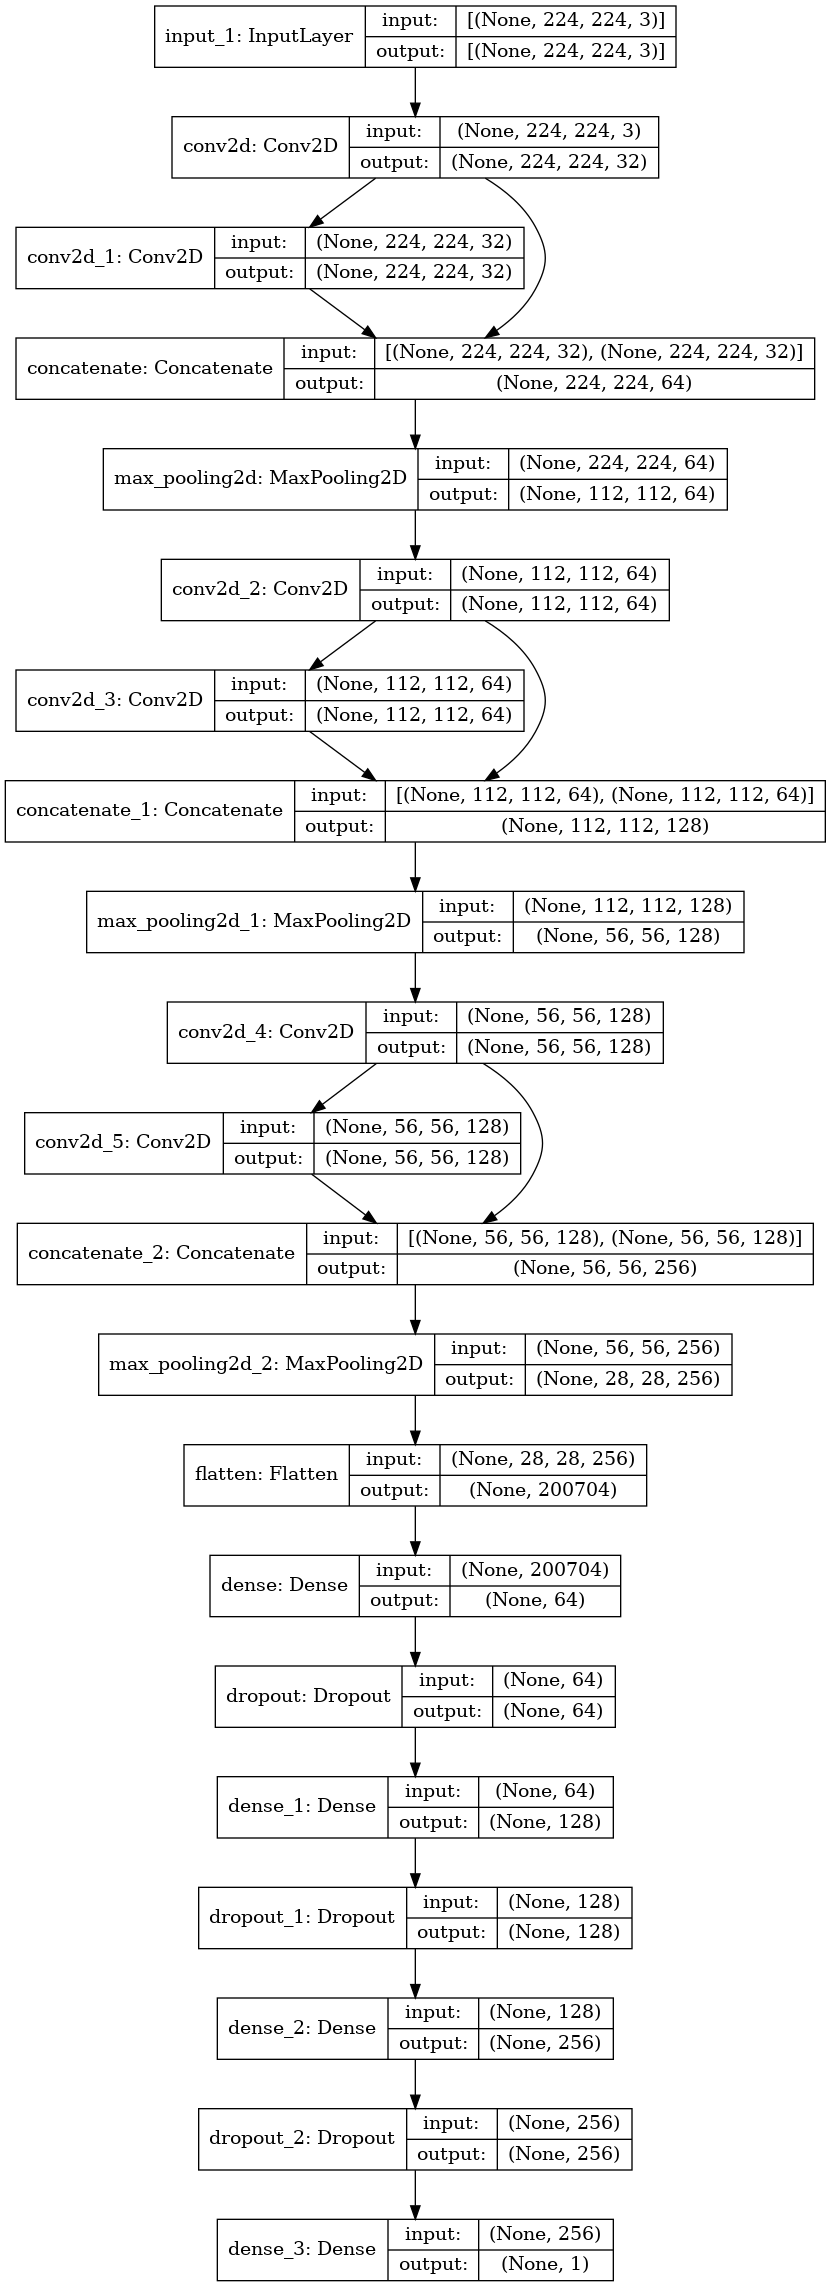

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [14]:
model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [15]:
EPOCHS = 100
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1)

es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[es]
)

filename = 'hybrid_model.h5'
check_pt = ModelCheckpoint(
    filename,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True
)

history = model.fit(train_generator, epochs=EPOCHS, batch_size=16, validation_data=val_generator, callbacks=[reduce_lr, es, check_pt])

2021-11-17 10:35:34.185771: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-11-17 10:35:36.172678: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


48/48 [==============================] - 15s 153ms/step - loss: 0.6996 - accuracy: 0.5065 - val_loss: 0.6791 - val_accuracy: 0.5234
Epoch 2/100
48/48 [==============================] - 7s 140ms/step - loss: 0.6733 - accuracy: 0.5723 - val_loss: 0.6616 - val_accuracy: 0.5234
Epoch 3/100
48/48 [==============================] - 7s 145ms/step - loss: 0.6415 - accuracy: 0.6361 - val_loss: 0.5909 - val_accuracy: 0.6589
Epoch 4/100
48/48 [==============================] - 8s 166ms/step - loss: 0.5735 - accuracy: 0.7096 - val_loss: 0.4600 - val_accuracy: 0.8099
Epoch 5/100
48/48 [==============================] - 8s 163ms/step - loss: 0.4936 - accuracy: 0.7734 - val_loss: 0.4138 - val_accuracy: 0.8281
Epoch 6/100
48/48 [==============================] - 7s 150ms/step - loss: 0.4329 - accuracy: 0.8125 - val_loss: 0.3416 - val_accuracy: 0.8620
Epoch 7/100
48/48 [==============================] - 7s 145ms/step - loss: 0.3994 - accuracy: 0.8411 - val_loss: 0.3354 - val_accuracy: 0.8568
Epoch 8/10

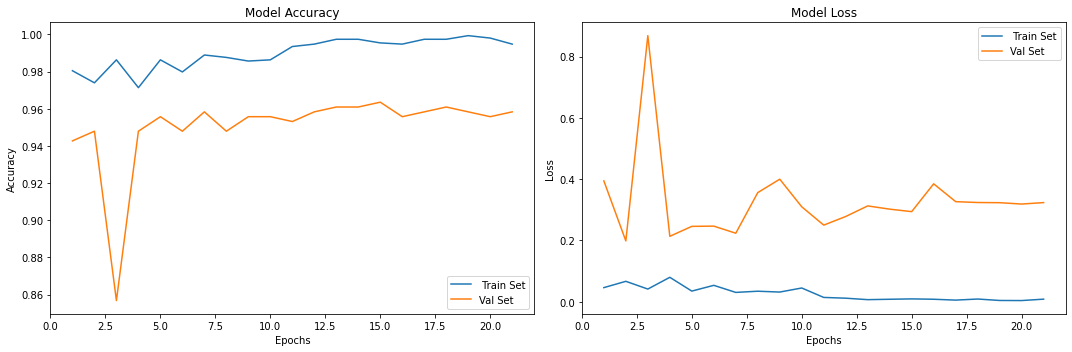

In [16]:
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history["accuracy"], label=' Train Set')
plt.plot(epochs_range, history.history["val_accuracy"], label='Val Set')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history["loss"], label=' Train Set')
plt.plot(epochs_range, history.history["val_loss"], label='Val Set')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend(loc="best")
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [19]:
from tensorflow.keras.models import load_model
saved_model = load_model('./hybrid_model.h5')

In [20]:
# validation set
predictions = model.predict(X_val)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)

print('Train: %.4f, Val: %.4f' % (train_acc, val_acc))

accuracy = accuracy_score(y_val, predictions)
print('Validation Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_val, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_val, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_val, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

Train: 0.9427, Val: 0.9115
Validation Accuracy = 0.9115
Precision: 0.859091
Recall: 0.984375
F1 score: 0.917476
Cohens kappa: 0.822917
ROC AUC: 0.911458
[[161  31]
 [  3 189]]
True positive: 189 , True negative: 161 , False positive: 31 , False negative: 3


In [22]:
# test set
predictions = model.predict(X_test)
predictions = [1 if x>0.5 else 0 for x in predictions]

_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.4f' % accuracy)

# precision: tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %f' % precision)

  # recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %f' % recall)

  # f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %f' % f1)

#KAPPA SCORE
kappa = cohen_kappa_score(y_test, predictions)
print('Cohens kappa: %f' % kappa)

  # ROC AUC
auc = roc_auc_score(y_test, predictions)
print('ROC AUC: %f' % auc)
 
# confusion matrix
matrix = confusion_matrix(y_test, predictions)
print(matrix)

tn, fp, fn, tp = matrix.ravel()
print("True positive:", tp, ", True negative:", tn,
            ", False positive:", fp, ", False negative:", fn)

Train: 0.9427, Test: 0.8917
Test Accuracy = 0.8917
Precision: 0.828671
Recall: 0.987500
F1 score: 0.901141
Cohens kappa: 0.783333
ROC AUC: 0.891667
[[191  49]
 [  3 237]]
True positive: 237 , True negative: 191 , False positive: 49 , False negative: 3
